## Import libraries

In [23]:
import requests
import pandas as pd
import json
from pymongo import MongoClient
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
from psycopg2 import sql
import folium


## Fetch data from the API

In [24]:
# Fetch data from the API
url = 'https://data.ny.gov/resource/39hk-dx4f.json'
response = requests.get(url)

if response.status_code == 200:
    print("Data fetched successfully")
    data = response.json()
    data_dict = {'meta': {}, 'data': data}
    # print(data_dict.keys())
    subway_data = data_dict['data']

    df=pd.DataFrame(subway_data)

    print("Fetched Data:")
    print(df.head())
else:
    print(f"Failed to fetch data. Status code: {response.status_code}")


Data fetched successfully
Fetched Data:
  gtfs_stop_id station_id complex_id division     line             stop_name  \
0          R01          1          1      BMT  Astoria  Astoria-Ditmars Blvd   
1          R03          2          2      BMT  Astoria          Astoria Blvd   
2          R04          3          3      BMT  Astoria                 30 Av   
3          R05          4          4      BMT  Astoria              Broadway   
4          R06          5          5      BMT  Astoria                 36 Av   

  borough    cbd daytime_routes structure  ... north_direction_label  \
0       Q  FALSE            N W  Elevated  ...             Last Stop   
1       Q  FALSE            N W  Elevated  ...               Astoria   
2       Q  FALSE            N W  Elevated  ...               Astoria   
3       Q  FALSE            N W  Elevated  ...               Astoria   
4       Q  FALSE            N W  Elevated  ...               Astoria   

  south_direction_label ada ada_northbound ada

## Connect to MongoDB and Insert fetched data into MongoDB

In [25]:
if not df.empty:
    # Comnnect to MongoDB
    client = MongoClient("mongodb://%s:%s@127.0.0.1" % ("dap", "dap")) # Insert authentication for MongoDB here
    database = client['nyc_subway_db']
    collection = database['subway_data']

    # Comnnect to MongoDB 
    # client = MongoClient("mongodb://%s:%s@127.0.0.1" % ("<username>", "<password>"))
    # database = client['nyc_subway_db']
    # collection = database['subway_data']


    prepared_data = df.to_dict(orient='records')

    # Insert data into MongoDB
    print("\nInserting data into MongoDB...")
    insert_result = collection.insert_many(prepared_data)
    print(f"Inserted {len(insert_result.inserted_ids)} records into MongoDB.")

    sample = collection.find_one()
    print("Sample record from MongoDB:", sample)

else:
    print("No data to insert into Mongo")


Inserting data into MongoDB...
Inserted 496 records into MongoDB.
Sample record from MongoDB: {'_id': ObjectId('675b71e3ce16d48b07659324'), 'gtfs_stop_id': 'R01', 'station_id': '1', 'complex_id': '1', 'division': 'BMT', 'line': 'Astoria', 'stop_name': 'Astoria-Ditmars Blvd', 'borough': 'Q', 'cbd': 'FALSE', 'daytime_routes': 'N W', 'structure': 'Elevated', 'gtfs_latitude': '40.775036', 'gtfs_longitude': '-73.912034', 'north_direction_label': 'Last Stop', 'south_direction_label': 'Manhattan', 'ada': '0', 'ada_northbound': '0', 'ada_southbound': '0', 'georeference': {'type': 'Point', 'coordinates': [-73.912034, 40.775036]}, ':@computed_region_yamh_8v7k': '196', ':@computed_region_wbg7_3whc': '877', ':@computed_region_kjdx_g34t': '2137', 'ada_notes': nan}


In [26]:
#Fetch data from MongoDB
subway_data = collection.find()

subway_station_list = list(subway_data) 

if subway_station_list:
    print(f"Fetched {len(subway_station_list)} records from MongoDB.")
    subway_station_df = pd.DataFrame(subway_station_list)
else:
    print("No data found in MongoDB!")

print(subway_station_df.columns)
print(subway_station_df.head())


Fetched 1488 records from MongoDB.
Index(['_id', 'gtfs_stop_id', 'station_id', 'complex_id', 'division', 'line',
       'stop_name', 'borough', 'cbd', 'daytime_routes', 'structure',
       'gtfs_latitude', 'gtfs_longitude', 'north_direction_label',
       'south_direction_label', 'ada', 'ada_northbound', 'ada_southbound',
       'georeference', ':@computed_region_yamh_8v7k',
       ':@computed_region_wbg7_3whc', ':@computed_region_kjdx_g34t',
       'ada_notes'],
      dtype='object')
                        _id gtfs_stop_id station_id complex_id division  \
0  675b71e3ce16d48b07659324          R01          1          1      BMT   
1  675b71e3ce16d48b07659325          R03          2          2      BMT   
2  675b71e3ce16d48b07659326          R04          3          3      BMT   
3  675b71e3ce16d48b07659327          R05          4          4      BMT   
4  675b71e3ce16d48b07659328          R06          5          5      BMT   

      line             stop_name borough    cbd daytime_rou

## Clean and Transform the data

In [27]:
def clean_subway_data(subway_df):
    
    try:
        # Create a copy to avoid modifying the original DataFrame
        subway_clean = subway_df.copy()

        # Define column mappings
        column_mapping = {
            'stop_name': 'station_name',
            'gtfs_latitude': 'latitude',
            'gtfs_longitude': 'longitude',
            'daytime_routes': 'lines'
        }

        # Rename columns
        subway_clean = subway_clean.rename(columns=column_mapping)

        # Convert latitude and longitude to numeric values
        subway_clean['latitude'] = pd.to_numeric(subway_clean['latitude'], errors='coerce')
        subway_clean['longitude'] = pd.to_numeric(subway_clean['longitude'], errors='coerce')

        # Drop rows with missing critical data
        subway_clean = subway_clean.dropna(subset=['station_name', 'latitude', 'longitude'])

        # Remove duplicates based on station name
        subway_clean = subway_clean.drop_duplicates(subset=['station_name'])

        # Verify coordinate ranges for NYC
        subway_clean = subway_clean[
            (subway_clean['latitude'] >= 40.4) & 
            (subway_clean['latitude'] <= 41.0) & 
            (subway_clean['longitude'] >= -74.3) & 
            (subway_clean['longitude'] <= -73.7)
        ]

        print("Subway data cleaned successfully!")
        return subway_clean

    except Exception as e:
        print(f"Error processing subway data: {str(e)}")
        return pd.DataFrame()  # Return an empty DataFrame on error

# Usage example:
subway_cleaned = clean_subway_data(subway_station_df)
print(subway_cleaned.head())


Subway data cleaned successfully!
                        _id gtfs_stop_id station_id complex_id division  \
0  675b71e3ce16d48b07659324          R01          1          1      BMT   
1  675b71e3ce16d48b07659325          R03          2          2      BMT   
2  675b71e3ce16d48b07659326          R04          3          3      BMT   
3  675b71e3ce16d48b07659327          R05          4          4      BMT   
4  675b71e3ce16d48b07659328          R06          5          5      BMT   

      line          station_name borough    cbd lines  ...  \
0  Astoria  Astoria-Ditmars Blvd       Q  FALSE   N W  ...   
1  Astoria          Astoria Blvd       Q  FALSE   N W  ...   
2  Astoria                 30 Av       Q  FALSE   N W  ...   
3  Astoria              Broadway       Q  FALSE   N W  ...   
4  Astoria                 36 Av       Q  FALSE   N W  ...   

  north_direction_label  south_direction_label  ada ada_northbound  \
0             Last Stop              Manhattan    0              0   
1 

## Connect to PostgreSQL and Create Database Table

In [28]:
# import psycopg2

def setup_postgresql():
    # PostgreSQL connection
    try:
        conn = psycopg2.connect(
            dbname="exampledb",    
            user="docker",         
            password="docker",     
            host="localhost",
            port="5432"
        )
        # conn = psycopg2.connect(
        #     dbname="<dbname>",       # Replace with your database name
        #     user="<username>",       # Replace with your username
        #     password="<password>",   # Replace with your password
        #     host="localhost",
        #     port="5432"
        # )
        cur = conn.cursor()
        return conn, cur
    except Exception as e:
        print(f"Error connecting to PostgreSQL: {e}")
        return None, None

def create_subway_table(conn, cur):
    # Create a PostgreSQL table for subway data
    try:
        cur.execute("""
            CREATE TABLE IF NOT EXISTS subway_stations (
                station_name TEXT PRIMARY KEY,
                latitude FLOAT,
                longitude FLOAT,
                lines TEXT[]
            );
        """)
        conn.commit()
        print("Subway table created successfully")
    except Exception as e:
        print(f"Error creating table: {e}")
        conn.rollback()

# Initialize PostgreSQL connection
pg_conn, pg_cur = setup_postgresql()
if pg_conn and pg_cur:
    create_subway_table(pg_conn, pg_cur)


Subway table created successfully


## Insert Subway Data into PostgreSQL

In [29]:
def insert_subway_data(subway_df, conn, cur):
    """Insert subway data into PostgreSQL"""
    try:
        for _, row in subway_df.iterrows():
            # Convert lines to PostgreSQL array format
            lines = row.get('lines', '')
            if isinstance(lines, str):
                lines_array = '{' + ','.join(f'"{line.strip()}"' for line in lines.split()) + '}'
            else:
                lines_array = '{}'
            
            cur.execute("""
                INSERT INTO subway_stations (station_name, latitude, longitude, lines)
                VALUES (%s, %s, %s, %s)
                ON CONFLICT (station_name) DO NOTHING;
            """, (row.get('station_name'), row.get('latitude'), row.get('longitude'), lines_array))

        conn.commit()
        print("Subway data inserted successfully")
    except Exception as e:
        print(f"Error inserting data: {e}")
        conn.rollback()

# Insert data
if pg_conn and pg_cur:
    insert_subway_data(subway_cleaned, pg_conn, pg_cur)


Subway data inserted successfully


In [30]:
subway_cleaned.head()

,_id,gtfs_stop_id,station_id,complex_id,division,line,station_name,borough,cbd,lines,...,north_direction_label,south_direction_label,ada,ada_northbound,ada_southbound,georeference,:@computed_region_yamh_8v7k,:@computed_region_wbg7_3whc,:@computed_region_kjdx_g34t,ada_notes
0,675b71e3ce16d48b07659324,R01,1,1,BMT,Astoria,Astoria-Ditmars Blvd,Q,FALSE,N W,...,Last Stop,Manhattan,0,0,0,"{'type': 'Point', 'coordinates': [-73.912034, ...",196,877,2137,NaN
1,675b71e3ce16d48b07659325,R03,2,2,BMT,Astoria,Astoria Blvd,Q,FALSE,N W,...,Astoria,Manhattan,1,1,1,"{'type': 'Point', 'coordinates': [-73.917843, ...",196,874,2137,NaN
2,675b71e3ce16d48b07659326,R04,3,3,BMT,Astoria,30 Av,Q,FALSE,N W,...,Astoria,Manhattan,0,0,0,"{'type': 'Point', 'coordinates': [-73.921479, ...",196,874,2137,NaN
3,675b71e3ce16d48b07659327,R05,4,4,BMT,Astoria,Broadway,Q,FALSE,N W,...,Astoria,Manhattan,0,0,0,"{'type': 'Point', 'coordinates': [-73.925508, ...",196,878,2137,NaN
4,675b71e3ce16d48b07659328,R06,5,5,BMT,Astoria,36 Av,Q,FALSE,N W,...,Astoria,Manhattan,0,0,0,"{'type': 'Point', 'coordinates': [-73.929575, ...",196,878,2137,NaN


## Visualize the data

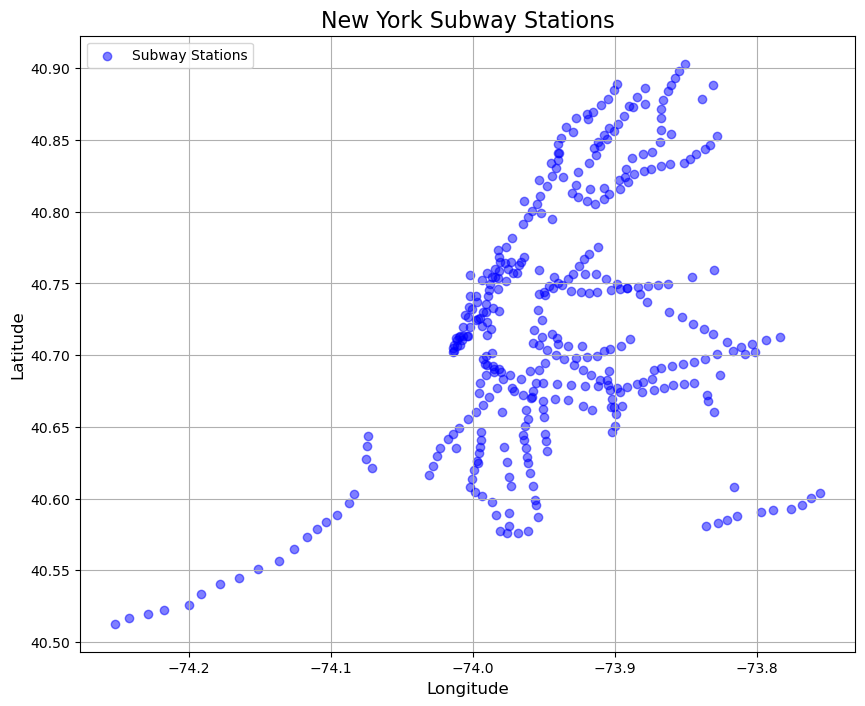

In [31]:
#Visualize subway station locations on a scatter plot
def plot_subway_stations(subway_df):
    plt.figure(figsize=(10, 8))
    plt.scatter(subway_df['longitude'], subway_df['latitude'], c='blue', alpha=0.5, label='Subway Stations')
    plt.title("New York Subway Stations", fontsize=16)
    plt.xlabel("Longitude", fontsize=12)
    plt.ylabel("Latitude", fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()
# Perform the plot
plot_subway_stations(subway_cleaned)



In [36]:

# Interactive map of subway stations
def create_subway_map(subway_df):
    subway_map = folium.Map(location=[40.7128, -74.0060], zoom_start=12)  # Centered on NYC
    for _, row in subway_df.iterrows():
        folium.Marker(
            location=[row['latitude'], row['longitude']],
            popup=f"Station: {row['station_name']}<br>Lines: {row['lines']}",
        ).add_to(subway_map)
    return subway_map

subway_map = create_subway_map(subway_cleaned)
# subway_map.save("subway_map.html")
display(subway_map)



In [33]:
if pg_conn and pg_cur:
    pg_cur.close()
    pg_conn.close()
    print("PostgreSQL connection closed")


PostgreSQL connection closed
